In [1]:
!pip install scikit-posthocs
!pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.1 MB/s eta 0:00:00


In [2]:
import zipfile

# Define the path to the zip file
zip_path = "/content/Data for modelling.zip"
extract_path = "/content/Data_for_modelling"  # Folder to extract files

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [222]:
import pandas as pd
import numpy as np
ticker = 'BET'
df = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Frontier/BET/{ticker}.csv', index_col=0)
data = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Frontier/BET/{ticker}_return.csv')

data.index = df['Date']
data = data.dropna()

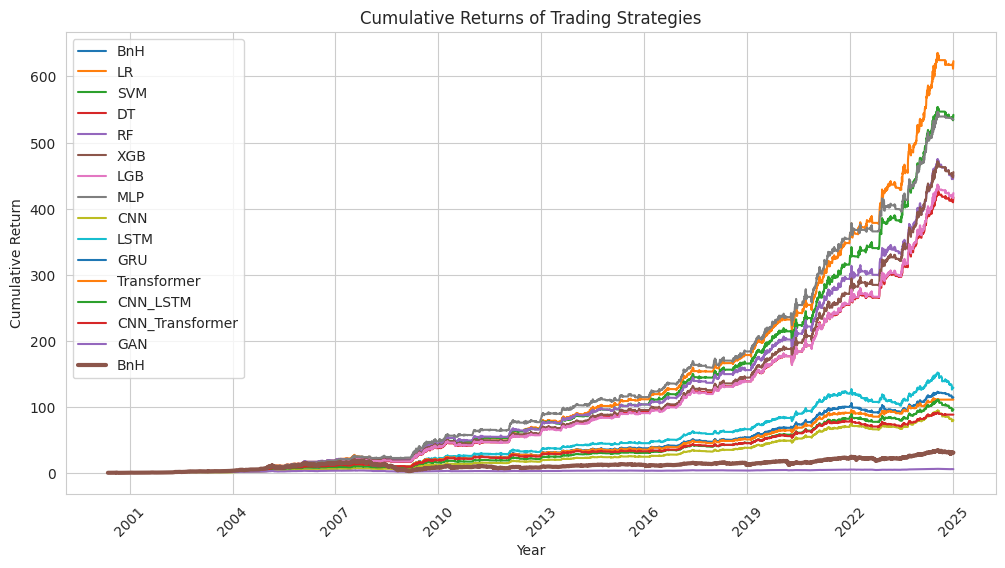

In [223]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure index is datetime
data.index = pd.to_datetime(data.index)

# Compute cumulative returns
cumulative_returns = (1 + data).cumprod()

# Plot
plt.figure(figsize=(12, 6))

for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.plot(cumulative_returns.index, cumulative_returns['BnH'], label='BnH', linewidth=3)

plt.title('Cumulative Returns of Trading Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()

# Format x-axis to show only years
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))  # Show every 3 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as YYYY
plt.xticks(rotation=45)  # Rotate labels if needed

plt.legend()
plt.title('Cumulative Returns of Trading Strategies')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.grid()
plt.savefig(f'/content/Data_for_modelling/Data for modelling/Frontier/BET/{ticker}_1.png')

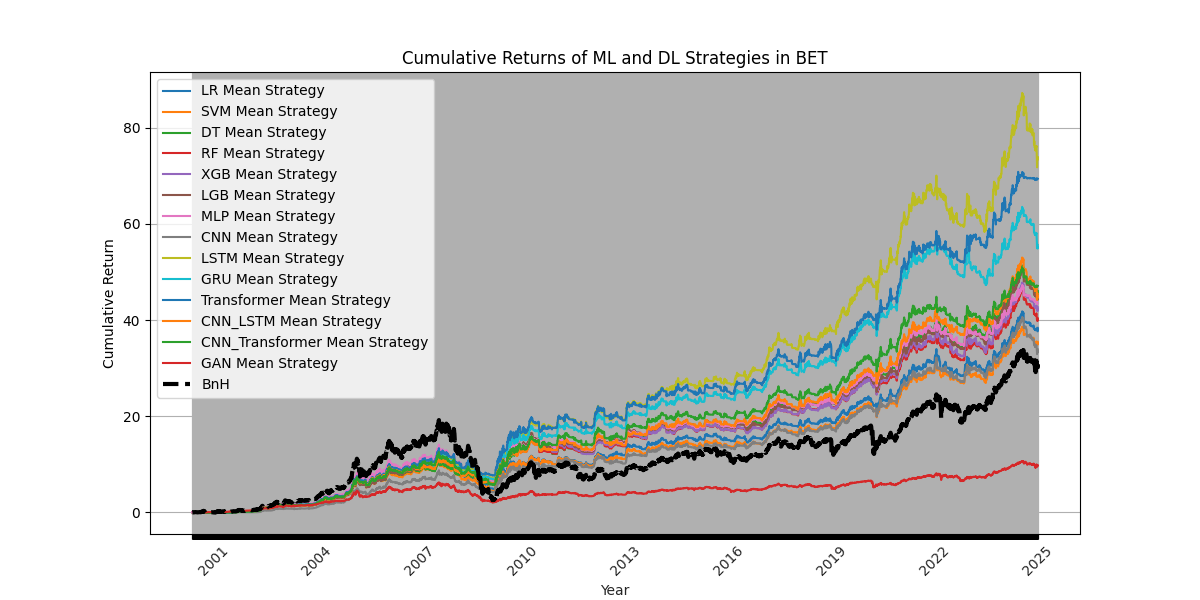

In [224]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import for Colab

# Load the two images
first_image = cv2.imread(f'/content/Data_for_modelling/Data for modelling/Frontier/BET/{ticker}.png')   # Update path
second_image = cv2.imread(f'/content/Data_for_modelling/Data for modelling/Frontier/BET/{ticker}_1.png') # Update path

# Convert images to grayscale to detect the date axis
gray_second = cv2.cvtColor(second_image, cv2.COLOR_BGR2GRAY)

# Crop the date axis from the second image (adjust if needed)
y_start = int(second_image.shape[0] * 0.9)  # Lower 10% contains the date axis
date_axis = second_image[y_start:, :]

# Remove the incorrect date axis from the first image (set that region to white)
first_image[y_start:, :] = 255  # White background

# Overlay the new date axis onto the first image
first_image[y_start:, :] = date_axis

# Save and display the fixed image
cv2.imwrite(f'/content/Data_for_modelling/Data for modelling/Frontier/BET/{ticker}_final.png', first_image)
cv2_imshow(first_image)  # Use this instead of cv2.imshow()


# **Compare return**

In [225]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Reshape data: Convert from wide format to long format
data_long = data.reset_index().melt(id_vars="Date", var_name="model", value_name="daily_return")

# Get unique models (including 'BnH')
models = data.columns.tolist()

# Convert data to the format required for Kruskal-Wallis test
returns_data = [data[model].dropna().values for model in models]  # Drop NaNs

# Perform Kruskal-Wallis test
print("\n📊 Performing Kruskal-Wallis test on daily returns...\n")
test_stat, p_value = stats.kruskal(*returns_data)

# Display Kruskal-Wallis test result
if p_value < 0.05:
    print(f"⚠️ Kruskal-Wallis Test Result: p={p_value:.4f} → Significant Difference Found!")

    # Perform Nemenyi post-hoc test
    nemenyi_test = sp.posthoc_nemenyi(data_long, val_col="daily_return", group_col="model")

    # Format Nemenyi results to 4 decimal places
    nemenyi_test = nemenyi_test.map(lambda x: f"{x:.4f}")

    # Display Nemenyi test results
    print("\n📊 Nemenyi Test Results for Daily Returns:\n")
    print(nemenyi_test.to_string(index=True))
else:
    print(f"✅ No significant difference found (p={p_value:.4f})")




📊 Performing Kruskal-Wallis test on daily returns...

✅ No significant difference found (p=0.1681)


In [226]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Calculate daily return statistics for each model
summary_stats = pd.DataFrame(index=data.columns)

summary_stats['Mean_Return'] = data.mean()  # Mean daily return
summary_stats['Std_Dev'] = data.std()  # Standard deviation (volatility)
summary_stats['Skewness'] = data.apply(skew)  # Skewness (asymmetry)
summary_stats['Kurtosis'] = data.apply(kurtosis)  # Kurtosis (tail risk)

# Display results rounded to 4 decimal places
print(summary_stats.round(4))

                 Mean_Return  Std_Dev  Skewness  Kurtosis
BnH                   0.0007   0.0141   -0.4567   10.3796
LR                    0.0011   0.0089    0.9083   13.7670
SVM                   0.0011   0.0088    0.9583   14.2774
DT                    0.0010   0.0088    0.9715   13.3598
RF                    0.0010   0.0089    0.8919   13.5969
XGB                   0.0010   0.0090    0.8547   13.3493
LGB                   0.0010   0.0090    0.8330   13.1378
MLP                   0.0011   0.0090    0.8858   13.2778
CNN                   0.0008   0.0087    0.4480   16.4234
LSTM                  0.0008   0.0095    0.4383   13.4681
GRU                   0.0008   0.0093    0.4985   13.4170
Transformer           0.0008   0.0096    0.3140   13.5712
CNN_LSTM              0.0008   0.0090    0.6827   13.8537
CNN_Transformer       0.0008   0.0091    0.3563   16.1023
GAN                   0.0003   0.0066   -0.3410    8.7069


In [227]:
metrics = ['Total Return [%]', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown [%]']
performance = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Frontier/BET/{ticker}_trading.csv', index_col=0)
print(performance.loc[metrics])

                                  LR                 SVM                  DT  \
Total Return [%]   3836.860320876812  3545.8092262460655   4604.954802859187   
Sharpe Ratio      1.2124472185718191  1.1956544981042978  1.2772268348991915   
Sortino Ratio     1.8163968340267036  1.7952742377223618  1.9392208766127268   
Max Drawdown [%]   51.82442928570487   51.97162320953881  41.181603334384356   

                                  RF                 XGB                 LGB  \
Total Return [%]   4033.991052855225   4266.195618031011   4502.547750419095   
Sharpe Ratio      1.2371485439526586  1.2482010169715099  1.2651490544014243   
Sortino Ratio     1.8596968423404163  1.8769989165248415  1.9165284147659485   
Max Drawdown [%]   45.67338937591602   45.94191414241839   41.52734932443767   

                                 MLP                 CNN                LSTM  \
Total Return [%]   4348.087010107348   3390.021001604425   7393.257173332951   
Sharpe Ratio      1.2400269914288284  

In [228]:
import vectorbt as vbt
bnh = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Frontier/BET/{ticker}.csv', index_col=0)
bnh.index = bnh['Date']
bnh['signal'] = [1]*len(bnh)

In [229]:
data['close'] = bnh['close']
data['signal'] = bnh['signal']

In [230]:
p1 = vbt.Portfolio.from_signals(
        close=bnh['close'],
        entries=bnh.signal==1,  # Entries where signal is 1
        exits=bnh.signal == 0,  # Exits where signal is 0
        size=1,  # Assuming equal position size
        fixed_fees=0.001,  # Example transaction cost
        slippage=0.001,
        freq='1d'
    )
p1.stats(agg_func=None).T.loc[metrics]

,0
Total Return [%],3077.195094
Sharpe Ratio,0.893925
Sortino Ratio,1.26431
Max Drawdown [%],82.548441


# **Accuracy**

In [231]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import numpy as np
import os

# Define parameters
models = ['LR', 'SVM', 'DT', 'RF', 'XGB', 'LGB', 'MLP',
          'CNN', 'LSTM', 'GRU', 'Transformer',
          'CNN_LSTM', 'CNN_Transformer', 'GAN']

base_path = "/content/Data_for_modelling/Data for modelling/Frontier/BET/"


# Load all model data into a single DataFrame
data_list = []
for model in models:
    file_path = os.path.join(base_path, f"{ticker}_{model}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['model'] = model  # Add model name column
        data_list.append(df)
        print(f"✅ Loaded {model} data successfully.")
    else:
        print(f"⚠️ {model} file not found at {file_path}. Skipping.")

# Merge all data
data = pd.concat(data_list, ignore_index=True)

# Get metric columns (excluding 'ticker' and 'model')
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'MCC', 'AUC']

# Store results
kruskal_results = {}
nemenyi_results = {}

# Loop through each metric
for metric in metrics:
    print(f"\n📊 Performing Kruskal-Wallis test for {metric}...\n")

    # Extract values for all models
    metric_values = [data[data['model'] == model][metric] for model in models if model in data['model'].unique()]

    # Perform Kruskal-Wallis test
    test_stat, p_value = stats.kruskal(*metric_values)

    # Store Kruskal-Wallis results
    kruskal_results[metric] = {'p_value': p_value}

    # Print Kruskal-Wallis results
    if p_value < 0.05:
        print(f"⚠️ Kruskal-Wallis Result: p={p_value:.4f} → Significant Difference!")

        # Perform Nemenyi post-hoc test (Corrected version)
        nemenyi_test = sp.posthoc_nemenyi(data, val_col=metric, group_col='model')

        # Store Nemenyi results
        nemenyi_results[metric] = nemenyi_test

        print(f"\n📊 Nemenyi Test Results for {metric}:\n")
        print(nemenyi_test.round(4))
    else:
        print(f"✅ No significant difference found (p={p_value:.4f})")

# Print summary of Kruskal-Wallis tests
print("\n🔹 Summary of Kruskal-Wallis Test Results:")
kruskal_summary_df = pd.DataFrame(kruskal_results).T
print(kruskal_summary_df.round(4))

# Print summary of Nemenyi test results (if any)
if nemenyi_results:
    print("\n🔹 Summary of Nemenyi Test Results:")
    for metric, result in nemenyi_results.items():
        print(f"\n📊 Nemenyi test for {metric}:\n")
        print(result.round(4))

✅ Loaded LR data successfully.
✅ Loaded SVM data successfully.
✅ Loaded DT data successfully.
✅ Loaded RF data successfully.
✅ Loaded XGB data successfully.
✅ Loaded LGB data successfully.
✅ Loaded MLP data successfully.
✅ Loaded CNN data successfully.
✅ Loaded LSTM data successfully.
✅ Loaded GRU data successfully.
✅ Loaded Transformer data successfully.
✅ Loaded CNN_LSTM data successfully.
✅ Loaded CNN_Transformer data successfully.
✅ Loaded GAN data successfully.

📊 Performing Kruskal-Wallis test for Accuracy...

⚠️ Kruskal-Wallis Result: p=0.0000 → Significant Difference!

📊 Nemenyi Test Results for Accuracy:

                    CNN  CNN_LSTM  CNN_Transformer      DT     GAN     GRU  \
CNN              1.0000    1.0000           1.0000  0.9071  0.0004  1.0000   
CNN_LSTM         1.0000    1.0000           1.0000  0.7595  0.0001  1.0000   
CNN_Transformer  1.0000    1.0000           1.0000  0.9863  0.0036  1.0000   
DT               0.9071    0.7595           0.9863  1.0000  0.5313

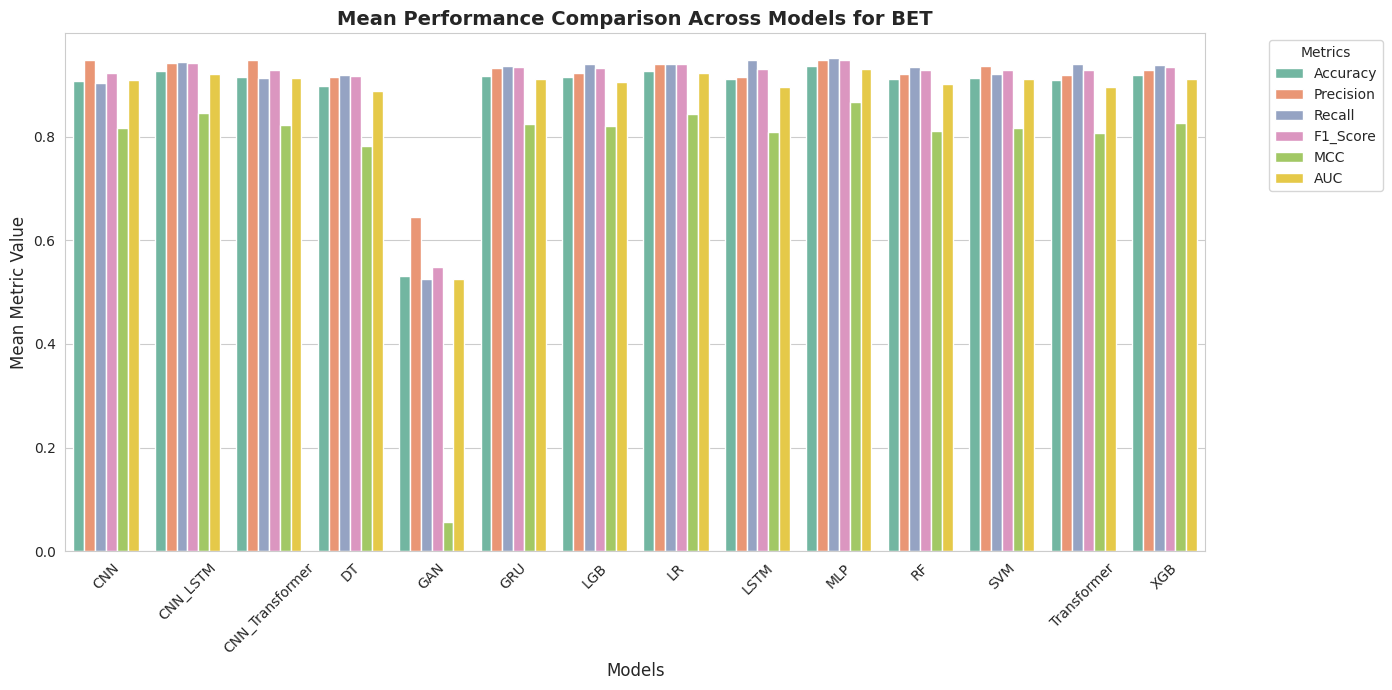

In [232]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import os
import matplotlib.pyplot as plt
import seaborn as sns
mean_performance = data.groupby('model')[metrics].mean().reset_index()

plt.figure(figsize=(14, 7))

# Reshape the data for Seaborn
data_melted = mean_performance.melt(id_vars=['model'], value_vars=metrics, var_name='Metric', value_name='Mean Value')

# Create a grouped bar plot
sns.set_style("whitegrid")
ax = sns.barplot(x='model', y='Mean Value', hue='Metric', data=data_melted, palette="Set2")

# Rotate x-axis labels for readability
plt.xticks(rotation=45)
plt.title(f"Mean Performance Comparison Across Models for {ticker}", fontsize=14, fontweight='bold')
plt.xlabel("Models", fontsize=12)
plt.ylabel("Mean Metric Value", fontsize=12)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [233]:
mean_performance.round(4)

,model,Accuracy,Precision,Recall,F1_Score,MCC,AUC
0,CNN,0.9078,0.9485,0.9040,0.9224,0.8168,0.9104
1,CNN_LSTM,0.9279,0.9430,0.9435,0.9425,0.8463,0.9220
2,CNN_Transformer,0.9150,0.9483,0.9143,0.9298,0.8236,0.9145
3,DT,0.8981,0.9158,0.9193,0.9171,0.7831,0.8890
4,GAN,0.5306,0.6447,0.5249,0.5490,0.0557,0.5246
5,GRU,0.9183,0.9338,0.9372,0.9350,0.8239,0.9108
6,LGB,0.9160,0.9233,0.9414,0.9321,0.8206,0.9067
7,LR,0.9272,0.9405,0.9411,0.9407,0.8448,0.9223
8,LSTM,0.9117,0.9158,0.9492,0.9313,0.8087,0.8971
9,MLP,0.9363,0.9490,0.9522,0.9493,0.8667,0.9305
